In [1]:
!pip install ultralytics

You should consider upgrading via the 'C:\Users\alira\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
! pip install torchviz
! pip install torchsummary
! pip install imblearn
!pip install efficientnet_pytorch
! pip install split-folders

You should consider upgrading via the 'C:\Users\alira\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\alira\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\alira\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\alira\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\alira\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:

import os
import gc  # Garbage collector for memory optimization
import copy
import time
import torch
import random
import pathlib
import torchvision
import splitfolders
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from torch import optim
from torchvision import utils
from torchviz import make_dot
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchsummary import summary
from PIL import Image, ImageFile
from sklearn.utils import resample
import torchvision.models as models
from collections import OrderedDict
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import LabelEncoder
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay , classification_report




In [4]:

# Set the TORCH_HOME environment variable
os.environ["TORCH_HOME"] = r"O:\O drive\AI\my project\medical image projects\Medical MNIST"

# Print the Torch hub directory to verify the location
print(torch.hub.get_dir())

# Print the value of TORCH_HOME to verify the environment variable
print(os.environ["TORCH_HOME"])


O:\O drive\AI\my project\medical image projects\Medical MNIST\hub
O:\O drive\AI\my project\medical image projects\Medical MNIST


In [5]:

torch.cuda.empty_cache()

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Data loading and spliting

In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def create_dataframe(root_dir):
    """
    Traverse the dataset folder structure and return a DataFrame with file paths and labels.
    
    Assumes the directory structure is:
        root_dir/
            class1/
                img1.png
                img2.png
                ...
            class2/
                ...
            ...
    
    Args:
        root_dir (str): The path to the dataset root.
        
    Returns:
        pd.DataFrame: DataFrame with columns ['file_path', 'label'].
    """
    data = []
    # List all subdirectories in the root (each subdirectory is a class)
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for filename in sorted(os.listdir(class_path)):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                    file_path = os.path.join(class_path, filename)
                    data.append({'file_path': file_path, 'label': class_name})
    df = pd.DataFrame(data)
    
    # Optionally encode labels as numbers (if needed for modeling)
    encoder = LabelEncoder()
    df['label_enc'] = encoder.fit_transform(df['label'])
    return df

# Set the dataset root directory (change this path as necessary)
root_directory = r"O:\O drive\AI\my project\medical image projects\Medical MNIST\Data"  # e.g., "/home/user/datasets/medical_images"

# Create the DataFrame
df = create_dataframe(root_directory)
print("Total images collected:", len(df))
print(df.head())

# Ensure reproducibility by sorting by file_path
df = df.sort_values("file_path").reset_index(drop=True)

# ---------------------------
# Split the data:
# - 10% test; 90% train+validation
# - Then split the train+validation into training and validation:
#      training = 70% of total, validation = 20% of total
#   Since train+val is 90% of total, set test_size=20/90≈0.2222 for validation.
# ---------------------------
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    random_state=42,
    stratify=df['label']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2222,  # ≈20% of total data (since train_val is 90%)
    random_state=42,
    stratify=train_val_df['label']
)

# Print split sizes
total = len(df)
print("\nFinal Splits:")
print(f"Training set: {len(train_df)} images ({len(train_df)/total*100:.1f}%)")
print(f"Validation set: {len(val_df)} images ({len(val_df)/total*100:.1f}%)")
print(f"Test set: {len(test_df)} images ({len(test_df)/total*100:.1f}%)")

# Optionally, save the splits to Excel files for further use
train_df.to_excel("train.xlsx", index=False)
val_df.to_excel("valid.xlsx", index=False)
test_df.to_excel("test.xlsx", index=False)

print("DataFrames saved to Excel files.")


Total images collected: 58954
                                           file_path      label  label_enc
0  O:\O drive\AI\my project\medical image project...  AbdomenCT          0
1  O:\O drive\AI\my project\medical image project...  AbdomenCT          0
2  O:\O drive\AI\my project\medical image project...  AbdomenCT          0
3  O:\O drive\AI\my project\medical image project...  AbdomenCT          0
4  O:\O drive\AI\my project\medical image project...  AbdomenCT          0

Final Splits:
Training set: 41268 images (70.0%)
Validation set: 11790 images (20.0%)
Test set: 5896 images (10.0%)
DataFrames saved to Excel files.


# Data analyzing 

In [7]:
train_df.shape

(41268, 3)

In [8]:
val_df.shape

(11790, 3)

In [9]:
test_df.shape

(5896, 3)

In [10]:
train_df.info

<bound method DataFrame.info of                                                file_path      label  label_enc
54190  O:\O drive\AI\my project\medical image project...     HeadCT          5
51158  O:\O drive\AI\my project\medical image project...     HeadCT          5
41691  O:\O drive\AI\my project\medical image project...       Hand          4
54034  O:\O drive\AI\my project\medical image project...     HeadCT          5
30203  O:\O drive\AI\my project\medical image project...    ChestCT          3
...                                                  ...        ...        ...
22554  O:\O drive\AI\my project\medical image project...        CXR          2
38237  O:\O drive\AI\my project\medical image project...    ChestCT          3
8094   O:\O drive\AI\my project\medical image project...  AbdomenCT          0
23791  O:\O drive\AI\my project\medical image project...        CXR          2
29744  O:\O drive\AI\my project\medical image project...    ChestCT          3

[41268 rows x 3 col

In [11]:
val_df.info

<bound method DataFrame.info of                                                file_path      label  label_enc
54615  O:\O drive\AI\my project\medical image project...     HeadCT          5
22198  O:\O drive\AI\my project\medical image project...        CXR          2
52865  O:\O drive\AI\my project\medical image project...     HeadCT          5
28153  O:\O drive\AI\my project\medical image project...        CXR          2
27853  O:\O drive\AI\my project\medical image project...        CXR          2
...                                                  ...        ...        ...
50609  O:\O drive\AI\my project\medical image project...     HeadCT          5
46847  O:\O drive\AI\my project\medical image project...       Hand          4
13842  O:\O drive\AI\my project\medical image project...  BreastMRI          1
30871  O:\O drive\AI\my project\medical image project...    ChestCT          3
19309  O:\O drive\AI\my project\medical image project...        CXR          2

[11790 rows x 3 col

In [12]:
test_df.info

<bound method DataFrame.info of                                                file_path      label  label_enc
19931  O:\O drive\AI\my project\medical image project...        CXR          2
32660  O:\O drive\AI\my project\medical image project...    ChestCT          3
26809  O:\O drive\AI\my project\medical image project...        CXR          2
22904  O:\O drive\AI\my project\medical image project...        CXR          2
8996   O:\O drive\AI\my project\medical image project...  AbdomenCT          0
...                                                  ...        ...        ...
4736   O:\O drive\AI\my project\medical image project...  AbdomenCT          0
40914  O:\O drive\AI\my project\medical image project...       Hand          4
54802  O:\O drive\AI\my project\medical image project...     HeadCT          5
44443  O:\O drive\AI\my project\medical image project...       Hand          4
43911  O:\O drive\AI\my project\medical image project...       Hand          4

[5896 rows x 3 colu

In [13]:
train_df.describe

<bound method NDFrame.describe of                                                file_path      label  label_enc
54190  O:\O drive\AI\my project\medical image project...     HeadCT          5
51158  O:\O drive\AI\my project\medical image project...     HeadCT          5
41691  O:\O drive\AI\my project\medical image project...       Hand          4
54034  O:\O drive\AI\my project\medical image project...     HeadCT          5
30203  O:\O drive\AI\my project\medical image project...    ChestCT          3
...                                                  ...        ...        ...
22554  O:\O drive\AI\my project\medical image project...        CXR          2
38237  O:\O drive\AI\my project\medical image project...    ChestCT          3
8094   O:\O drive\AI\my project\medical image project...  AbdomenCT          0
23791  O:\O drive\AI\my project\medical image project...        CXR          2
29744  O:\O drive\AI\my project\medical image project...    ChestCT          3

[41268 rows x 3 c

In [14]:
traindf_label_value_counts = train_df['label_enc'].value_counts()
validdf_label_value_counts = val_df['label_enc'].value_counts()
testdf_label_value_counts = test_df['label_enc'].value_counts()
print("distribution of train data")
print(traindf_label_value_counts)
print("distribution of valid data")
print(validdf_label_value_counts)
print("distribution of test data")
print(testdf_label_value_counts)

distribution of train data
label_enc
5    7000
4    7000
3    7000
0    7000
2    7000
1    6268
Name: count, dtype: int64
distribution of valid data
label_enc
5    2000
2    2000
3    2000
0    2000
4    2000
1    1790
Name: count, dtype: int64
distribution of test data
label_enc
2    1000
3    1000
0    1000
4    1000
5    1000
1     896
Name: count, dtype: int64


In [15]:
print(f'how many rows are duplicated in train dataset ? : {train_df.duplicated().sum()}')
print(f'how many rows are duplicated in valid dataset? : {val_df.duplicated().sum()}')
print(f'how many rows are duplicated in test dataset ? : {test_df.duplicated().sum()}')


how many rows are duplicated in train dataset ? : 0
how many rows are duplicated in valid dataset? : 0
how many rows are duplicated in test dataset ? : 0


In [16]:
classes_names = train_df['label'].unique()
print(f'classes names in dataset : {classes_names}')
classes_names_enc = train_df['label_enc'].unique()
print(f'classes encoded names in dataset : {classes_names_enc}')


classes names in dataset : ['HeadCT' 'Hand' 'ChestCT' 'AbdomenCT' 'BreastMRI' 'CXR']
classes encoded names in dataset : [5 4 3 0 1 2]


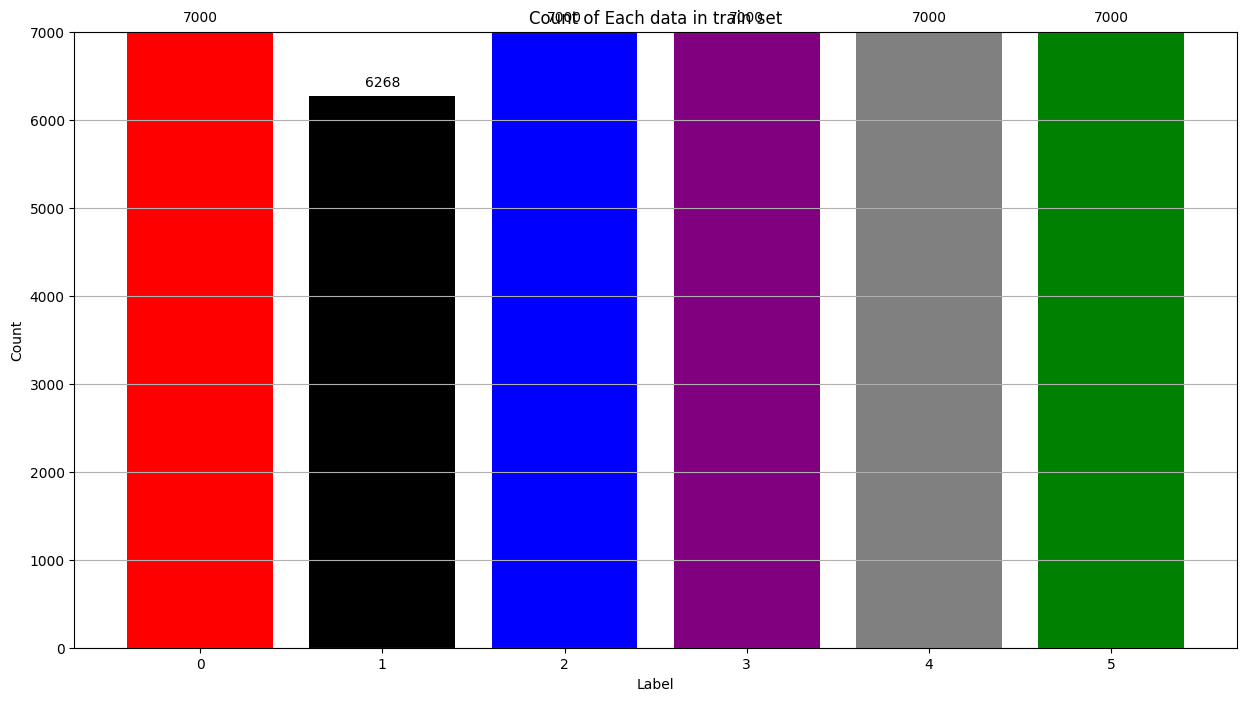

In [17]:
# Define a color for each label
colors = {
    0: 'red',
    1: 'black',
    2: 'blue',
    3: 'purple',
    4: 'gray',
    5: 'green'
}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(traindf_label_value_counts.index, traindf_label_value_counts.values, color=[colors[label] for label in traindf_label_value_counts.index])

# Set y-axis limit
plt.ylim(0, traindf_label_value_counts.max() + 1)

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above the bar
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each data in train set')
plt.grid(axis='y')
plt.show()


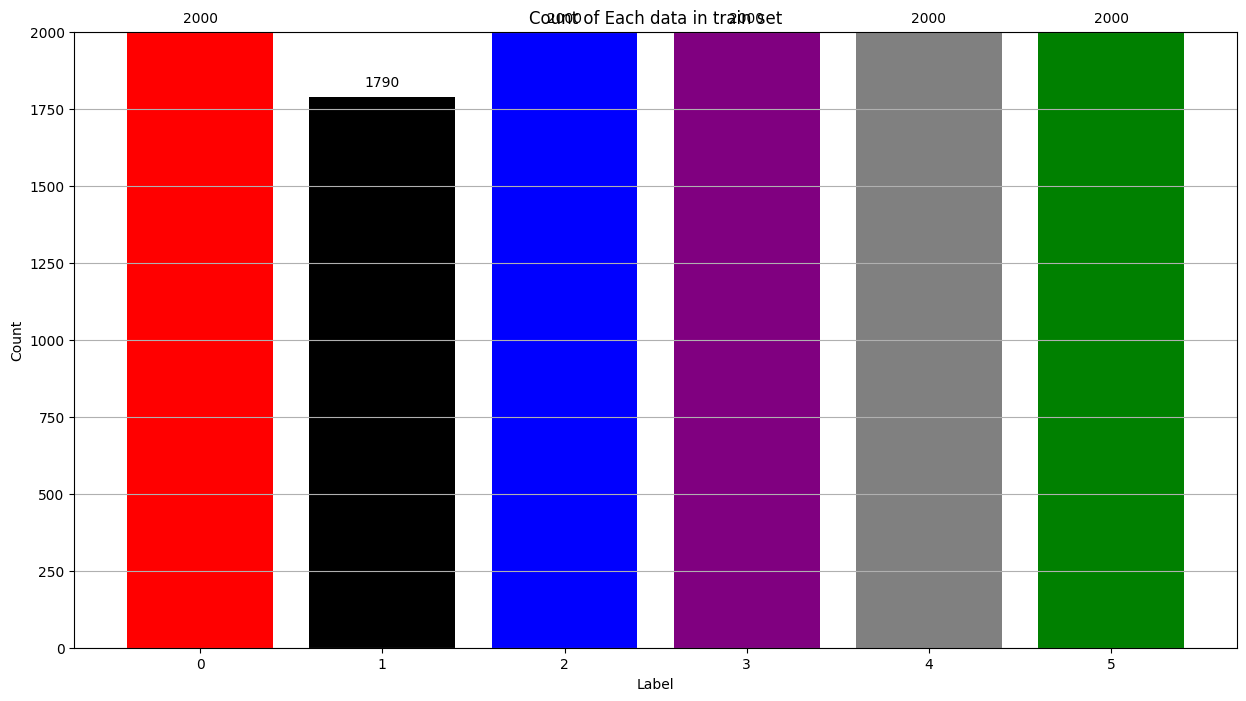

In [18]:
# Define a color for each label
colors = {
    0: 'red',
    1: 'black',
    2: 'blue',
    3: 'purple',
    4: 'gray',
    5: 'green'
}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(validdf_label_value_counts.index, validdf_label_value_counts.values, color=[colors[label] for label in validdf_label_value_counts.index])

# Set y-axis limit
plt.ylim(0, validdf_label_value_counts.max() + 1)

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above the bar
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each data in train set')
plt.grid(axis='y')
plt.show()


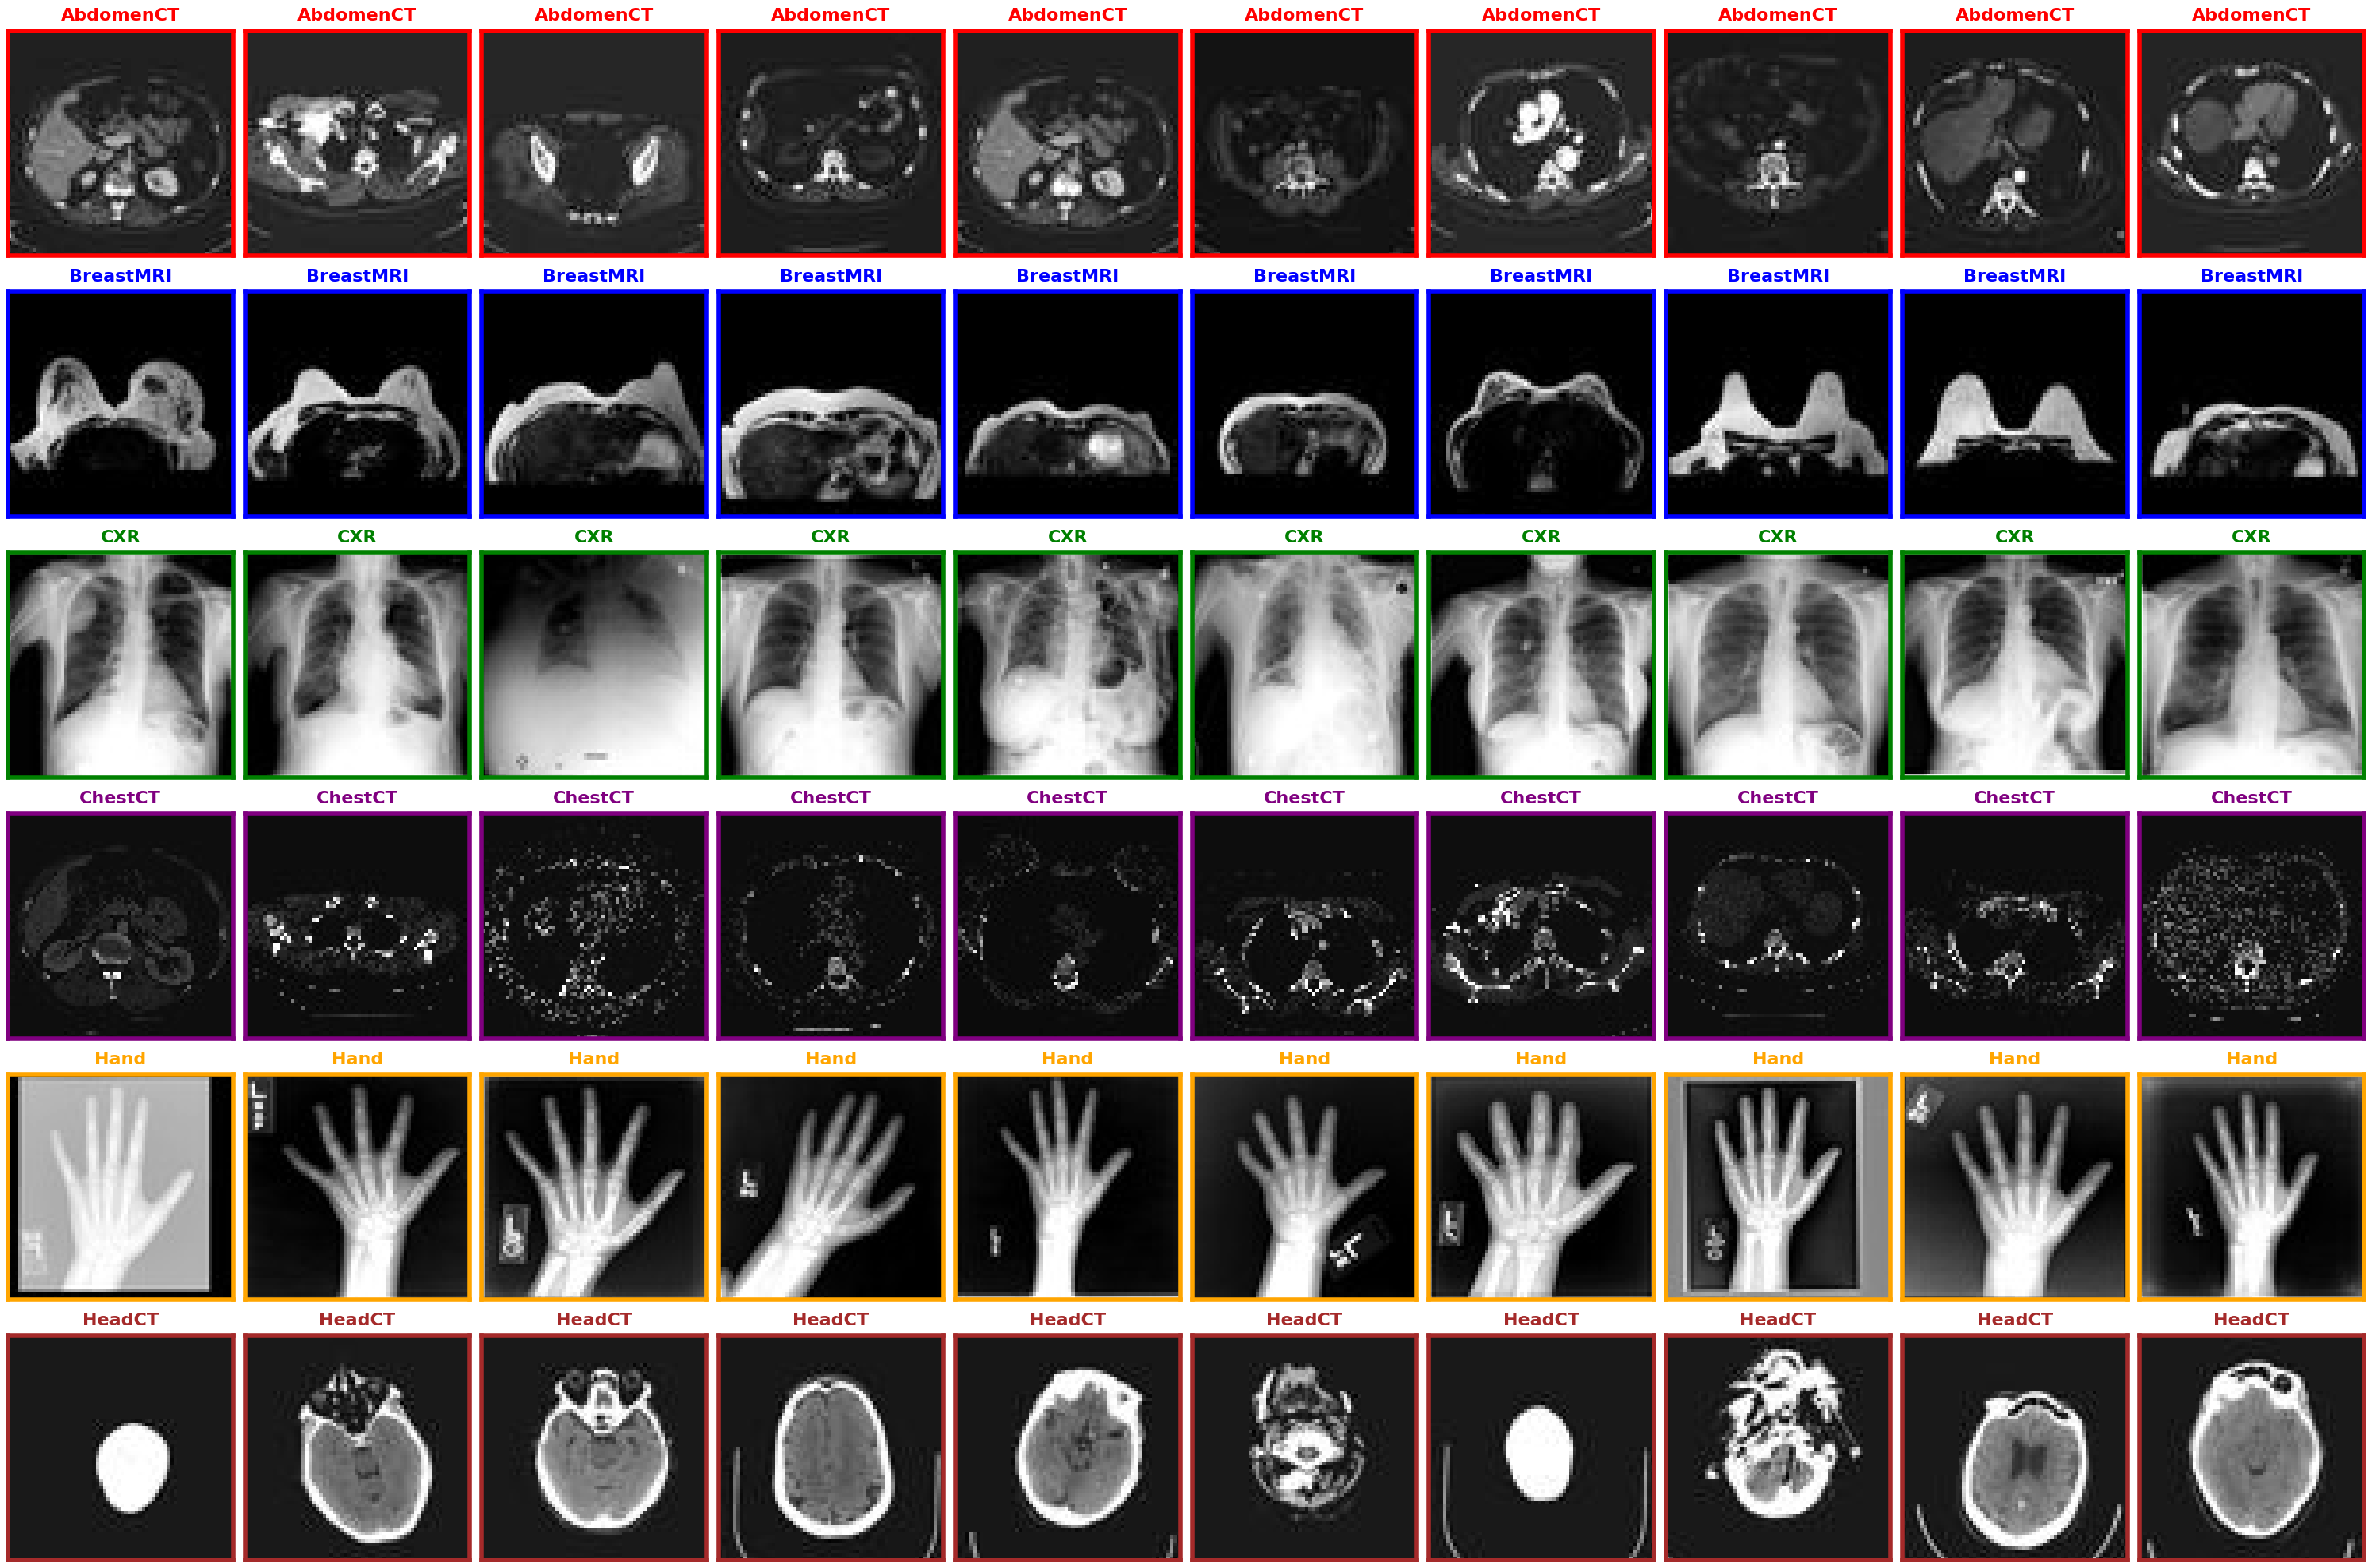

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Define class labels
class_labels = {
    0: "AbdomenCT",
    1: "BreastMRI",
    2: "CXR",
    3: "ChestCT",
    4: "Hand",
    5: "HeadCT"
}

# Define a unique color per class for border styling
class_colors = {
    "AbdomenCT": "red",
    "BreastMRI": "blue",
    "CXR": "green",
    "ChestCT": "purple",
    "Hand": "orange",
    "HeadCT": "brown"
}

# Collect file paths for each class
samples_per_class = 10
image_paths = {}

for label, class_name in class_labels.items():
    file_paths = train_df[train_df['label_enc'] == label]['file_path'].values
    image_paths[class_name] = np.random.choice(file_paths, min(samples_per_class, len(file_paths)), replace=False)

# Set up subplot grid
fig, axes = plt.subplots(nrows=6, ncols=10, figsize=(30, 20))

# Function to display images with fancy borders
def display_image(ax, img_path, title, border_color):
    try:
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap='gray')  # Display in grayscale
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title, fontsize=16, fontweight='bold', color=border_color, pad=10)

        # Add border effect by setting the edge color of the subplot
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(4)

    except Exception as e:
        ax.axis('off')  # Hide empty images if there's an issue

# Populate subplots with images
for row, (class_name, img_list) in enumerate(image_paths.items()):
    for col in range(len(img_list)):
        display_image(axes[row, col], img_list[col], class_name, class_colors[class_name])

# Tight layout and show the plot
plt.tight_layout()
plt.show()


# Balance data

In [20]:
from sklearn.utils import resample

# Get counts per class using encoded labels
class_counts = train_df['label_enc'].value_counts()
print("Original class distribution:\n", class_counts)

# Identify the minority class ("BreastMRI") and the target count from a majority class
target_count = class_counts[class_counts.index != train_df[train_df['label'] == "BreastMRI"]['label_enc'].iloc[0]].max()

# Separate the minority and majority classes
df_minority = train_df[train_df['label'] == "BreastMRI"]
df_majority = train_df[train_df['label'] != "BreastMRI"]

# Oversample the minority class to match the majority class
df_minority_oversampled = resample(
    df_minority,
    replace=True,      
    n_samples=target_count,  
    random_state=42    
)

# Combine the oversampled minority class with the majority classes
train_df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Shuffle the dataset to mix the samples
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Print new class distribution
print("\nNew class distribution after oversampling:")
print(train_df_balanced['label_enc'].value_counts())


Original class distribution:
 label_enc
5    7000
4    7000
3    7000
0    7000
2    7000
1    6268
Name: count, dtype: int64

New class distribution after oversampling:
label_enc
3    7000
1    7000
5    7000
0    7000
4    7000
2    7000
Name: count, dtype: int64


In [21]:
train_df_balanced.shape
train_df_balanced_label_value = train_df_balanced['label'].value_counts()

C:\Users\alira\AppData\Local\Temp\ipykernel_17312\3181626008.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap("tab10", len(train_df_balanced_label_value))


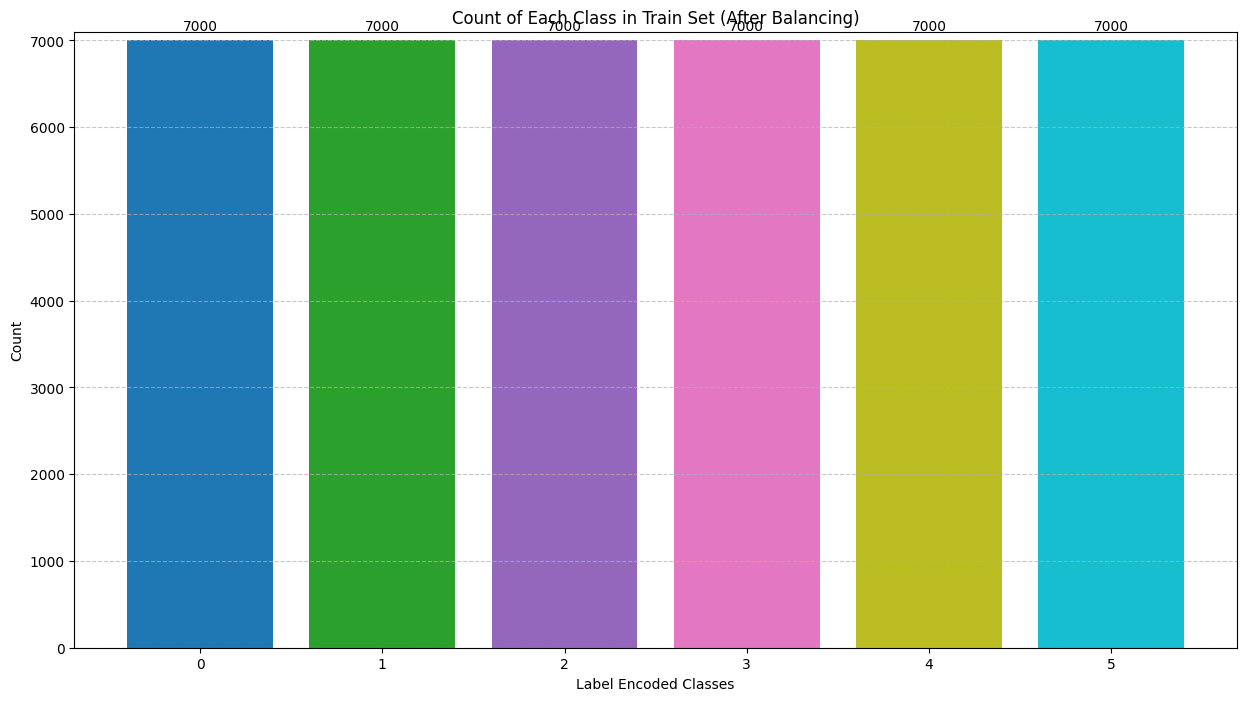

In [22]:
import matplotlib.pyplot as plt

# Get the class distribution
train_df_balanced_label_value = train_df_balanced['label_enc'].value_counts().sort_index()

# Define a color map dynamically for all labels
color_palette = plt.cm.get_cmap("tab10", len(train_df_balanced_label_value))
colors = {label: color_palette(i) for i, label in enumerate(train_df_balanced_label_value.index)}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(train_df_balanced_label_value.index, train_df_balanced_label_value.values, 
               color=[colors[label] for label in train_df_balanced_label_value.index])

# Set y-axis limit
plt.ylim(0, train_df_balanced_label_value.max() + 100)  # Adjust buffer dynamically

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Customize plot labels and title
plt.xlabel('Label Encoded Classes')
plt.ylabel('Count')
plt.title('Count of Each Class in Train Set (After Balancing)')
plt.xticks(ticks=train_df_balanced_label_value.index, labels=train_df_balanced_label_value.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# Data transformation and augmentation 

In [23]:
import os
import gc
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# ✅ Handle truncated/corrupted images gracefully
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ===========================================================
# 🔥 **Optimized Data Augmentation for Medical Imaging**
# ===========================================================

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Avoids excessive cropping
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),  # Slight rotation (CT/X-rays are orientation-sensitive)
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Mild translation (for minor spatial shifts)
    
    # ⚡ Contrast & Noise Adjustments
    transforms.ColorJitter(brightness=0.1, contrast=0.2),  
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),  # Reduces noise without blurring details
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),  # Keeps edges clear
    
    # ✅ Convert to Tensor and Normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Handles grayscale images too
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standardized resizing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# ===========================================================
# 🔥 **Custom Dataset with Enhanced Error Handling**
# ===========================================================
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        label = self.dataframe.iloc[idx]['label_enc']

        # ✅ Handle missing files gracefully
        if not os.path.isfile(img_path):
            print(f"⚠ Warning: Missing file {img_path}")
            return None

        try:
            img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
        except Exception as e:
            print(f"❌ Error loading image {img_path}: {e}")
            return None

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

# ===========================================================
# 🔥 **Create Optimized Datasets**
# ===========================================================
train_dataset = CustomDataset(train_df_balanced, transform=train_transform)
valid_dataset = CustomDataset(val_df, transform=test_transform)
test_dataset  = CustomDataset(test_df, transform=test_transform)

# ===========================================================
# 🔥 **Optimized DataLoaders for High-Speed Training**
# ===========================================================
BATCH_SIZE = 64  # Adjust based on GPU RAM

# Automatically set number of workers based on CPU/GPU
#NUM_WORKERS = min(4, os.cpu_count() // 2)  # Use half the available cores (max 4)
#PIN_MEMORY = torch.cuda.is_available()  # Enable for GPUs

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=0, pin_memory=False)

val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=0, pin_memory=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=0, pin_memory=False)

# ===========================================================
# 🔥 **Dataset Summary**
# ===========================================================
print(f"✅ Training dataset size: {len(train_loader.dataset)}")
print(f"✅ Validation dataset size: {len(val_loader.dataset)}")
print(f"✅ Test dataset size: {len(test_loader.dataset)}")

# ===========================================================
# 🔥 **Memory Optimization (Clearing GPU/CPU Cache)**
# ===========================================================
torch.cuda.empty_cache()  # Free up GPU memory
gc.collect()  # Force garbage collection to free RAM


✅ Training dataset size: 42000
✅ Validation dataset size: 11790
✅ Test dataset size: 5896


3974

In [24]:
print(f'how many batch do we have in train loader? :{len(train_loader)}')
print(f'how many batch do we have in validation loader? :{len(val_loader)}')
print(f'how many batch do we have in test loader? :{len(test_loader)}')


how many batch do we have in train loader? :657
how many batch do we have in validation loader? :185
how many batch do we have in test loader? :93


In [25]:


# Select CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check batch loading time
for i, (inputs, labels) in enumerate(train_loader):
    start_time = time.time()  # Start timing before fetching batch

    # Transfer batch to GPU (or CPU if CUDA is unavailable)
    inputs, labels = inputs.to(device), labels.to(device)

    batch_time = time.time() - start_time  # Compute batch loading time
    print(f"✅ Batch {i+1} Loaded in {batch_time:.4f} sec")

    if i == 4:  # Stop after 5 batches (0 to 4)
        break


Using device: cuda


C:\Users\alira\AppData\Local\Temp\ipykernel_17312\42890488.py:10: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  inputs, labels = inputs.to(device), labels.to(device)


✅ Batch 1 Loaded in 0.5481 sec
✅ Batch 2 Loaded in 0.0000 sec
✅ Batch 3 Loaded in 0.0000 sec
✅ Batch 4 Loaded in 0.0000 sec
✅ Batch 5 Loaded in 0.0000 sec


C:\Users\alira\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


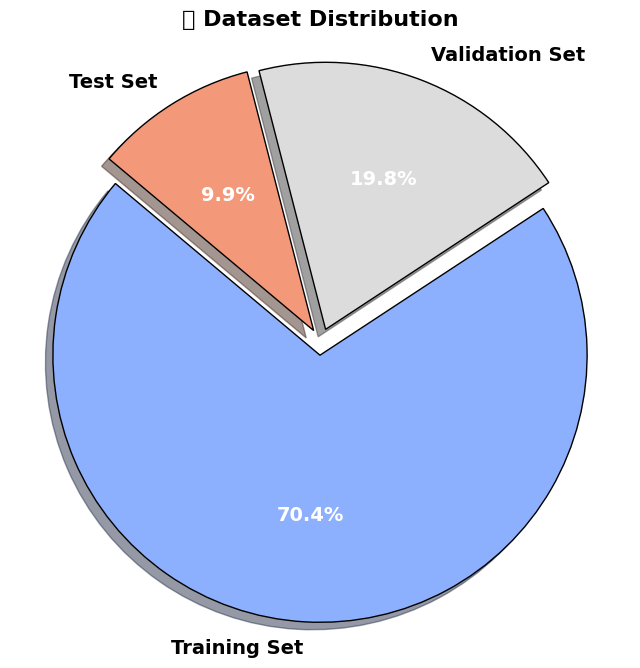

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a professional pie chart
def plot_pie_chart(sizes, labels, title):
    colors = sns.color_palette("coolwarm", len(sizes))  # Modern color palette
    explode = [0.05] * len(sizes)  # Slightly "explode" all sections for emphasis

    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, explode=explode, shadow=True, wedgeprops={'edgecolor': 'black'}
    )

    # Customize text appearance
    for text in texts:
        text.set_fontsize(14)
        text.set_fontweight('bold')

    for autotext in autotexts:
        autotext.set_fontsize(14)
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('equal')  # Keep the pie circular
    plt.show()

# Get the dataset sizes
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)
test_size = len(test_loader.dataset)

# Labels and sizes
sizes = [train_size, val_size, test_size]
labels = ['Training Set', 'Validation Set', 'Test Set']

# Plot the pie chart
plot_pie_chart(sizes, labels, '📊 Dataset Distribution')


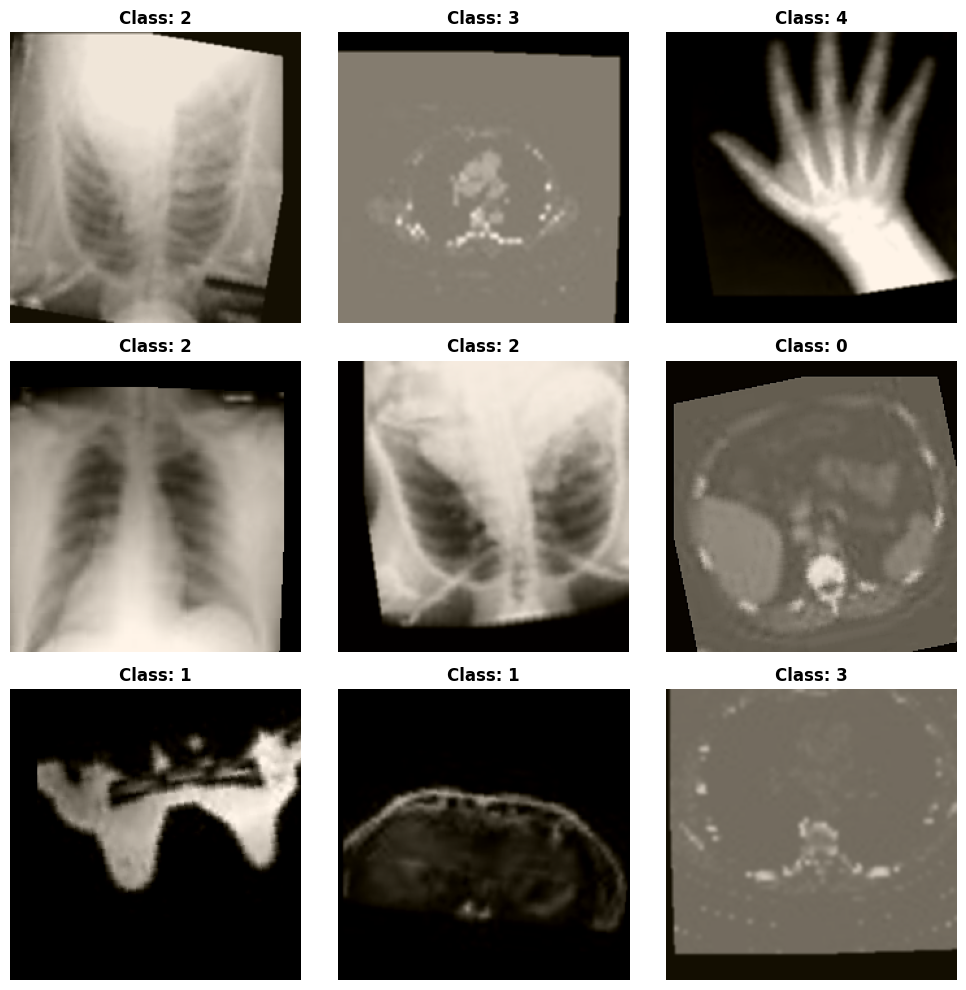

In [27]:
# Function to denormalize an image (if normalized earlier)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if isinstance(tensor, torch.Tensor):  # Convert only if it's a tensor
        tensor = tensor.clone().detach().numpy()
    
    for i in range(3):  # Assuming RGB
        tensor[i] = tensor[i] * std[i] + mean[i]
    
    return np.clip(tensor, 0, 1)  # Clip values to valid range

# Function to display multiple images
def show_multiple_samples(dataset, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    for ax in axes.flatten():
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        
        if isinstance(img, torch.Tensor):  
            img = img.numpy()  # Convert to NumPy if it's a tensor
        
        img = denormalize(img)  
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        
        ax.imshow(img)
        ax.set_title(f"Class: {label}", fontsize=12, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Test the function
show_multiple_samples(train_dataset)


# Modeling

In [28]:
!nvidia-smi

Sun Feb 23 06:42:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P3             14W /   62W |     119MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [43]:

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    # Get the current device
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device: {current_device}")

    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")






CUDA is available!
Current CUDA device: 0
Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler
from torchsummary import summary

# ✅ ResNeXt Model for Multi-Class Classification
class ResNeXtClassifier(nn.Module):
    def __init__(self, num_classes=6):  # Multi-class setup
        super(ResNeXtClassifier, self).__init__()
        self.resnext = models.resnext50_32x4d(pretrained=True)

        # Freeze early layers to retain pre-trained features
        for param in self.resnext.parameters():
            param.requires_grad = False

        # Unfreeze last few layers for fine-tuning
        for param in self.resnext.layer4.parameters():  
            param.requires_grad = True  

        # Replace the final fully connected layer for 6-class classification
        in_features = self.resnext.fc.in_features
        self.resnext.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnext(x)

# ✅ Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Initialize model
model = ResNeXtClassifier(num_classes=6).to(device)

# ✅ Print Model Summary
summary(model, (3, 64, 64))  # Adjusted input shape to match original 64x64 images


C:\Users\alira\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\alira\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]           8,192
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]           4,608
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          32,768
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [52]:
# ✅ Define Hyperparameters
num_epochs = 50
lr = 2e-4  # Increased for better convergence
weight_decay = 1e-4  # Moderate regularization

# ✅ Loss Function: Use CrossEntropyLoss (for Multi-Class)
loss_fn = nn.CrossEntropyLoss()

# ✅ Optimizer: AdamW (Better Generalization)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# ✅ Learning Rate Scheduler: Cosine Annealing + ReduceLROnPlateau
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  # Cosine decay

# ✅ Gradient Scaling for Mixed Precision Training (Speed & Stability)
scaler = GradScaler()

# ✅ Model Training Check
print(f"✅ Model Initialized on {device}")


✅ Model Initialized on cuda


C:\Users\alira\AppData\Local\Temp\ipykernel_17312\339243317.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [53]:
import os

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, monitor='loss'):
        """
        patience: How many epochs to wait before stopping.
        verbose: Whether to print progress.
        delta: Minimum change to qualify as an improvement.
        monitor: What to monitor ('loss' or 'accuracy').
        """
        self.patience = patience  
        self.verbose = verbose  
        self.counter = 0  
        self.best_score = float('inf') if monitor == 'loss' else -float('inf')  # Initialize based on monitor type
        self.best_epoch = 0  
        self.early_stop = False  
        self.delta = delta  
        self.monitor = monitor  # What to monitor: 'loss' or 'accuracy'

    def __call__(self, val_score, epoch, model_weights, model_name_prefix):
        """
        val_score: The validation loss/accuracy in the current epoch.
        epoch: The current epoch.
        model_weights: The weights of the model (usually model.state_dict()).
        model_name_prefix: The prefix for the model's name (e.g., 'model_1', 'model_2').
        """
        # If monitoring 'loss', we expect the value to decrease
        if self.monitor == 'loss':
            if val_score < self.best_score - self.delta:
                self.best_score = val_score
                self.best_epoch = epoch  
                self.counter = 0  
                self.save_best_weights(model_weights, model_name_prefix)  
            else:
                self.counter += 1  
        # If monitoring 'accuracy', we expect the value to increase
        elif self.monitor == 'accuracy':
            if val_score > self.best_score + self.delta:
                self.best_score = val_score
                self.best_epoch = epoch  
                self.counter = 0  
                self.save_best_weights(model_weights, model_name_prefix)  
            else:
                self.counter += 1  

        if self.counter >= self.patience:  
            self.early_stop = True
            if self.verbose:
                print(f"Early stopping triggered after {self.counter} epochs of no improvement.")

    def save_best_weights(self, model_weights, model_name_prefix):
        """
        Save the model weights with a unique name for each model.
        model_name_prefix: The prefix for the model's name (e.g., 'model_1', 'model_2').
        """
        model_name = f"{model_name_prefix}_epoch_{self.best_epoch + 1}.pth"
        
        # Clean up previous saved model files (optional, to avoid disk clutter)
        for file in os.listdir():
            if file.startswith(model_name_prefix) and file != model_name:
                os.remove(file)
                if self.verbose:
                    print(f"🗑️ Deleted old model file: {file}")
        
        torch.save(model_weights, model_name)  
        if self.verbose:
            print(f"✅ Best model weights saved to {model_name}.")


In [54]:
import torch
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.cuda.amp as amp
from sklearn.metrics import f1_score, accuracy_score

# Training loop
best_val_loss = float('inf')  # Initialize best validation loss
best_model_weights = None

def train_and_validate(model, train_loader, valid_loader, optimizer, scheduler, criterion, model_name_prefix, epochs=25, device=None, early_stopping=None):
  
    # Store losses and accuracies
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    auc_scores = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 50)

        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Ensure labels are Long for CrossEntropyLoss
            labels = labels.long()  # Cast labels to Long
            
            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                raw_outputs = model(inputs)  # Get raw logits (not passed through softmax)
                loss = criterion(raw_outputs, labels)  # Compute loss

            # Backward pass with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)

            # Compute predictions (Get class with highest logit)
            with torch.no_grad():
                _, preds = torch.max(raw_outputs, 1)  # Preds are class indices
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / total_preds
        print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Store training loss and accuracy
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Ensure labels are Long for CrossEntropyLoss
                labels = labels.long()  # Cast labels to Long
                
                with torch.cuda.amp.autocast():
                    raw_outputs = model(inputs)  # Get raw logits
                    loss = criterion(raw_outputs, labels)  # Compute loss
                
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(raw_outputs, 1)  # Preds are class indices
                correct_preds += torch.sum(preds == labels.data)
                total_preds += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(valid_loader.dataset)
        epoch_acc = correct_preds.double() / total_preds
        print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Store validation loss and accuracy
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_acc.item())

        
        # Step the scheduler based on validation loss
        scheduler.step(epoch_loss)

        # ✅ Early stopping check: save model based on validation loss
        if early_stopping is not None:
            early_stopping(epoch_loss, epoch, model.state_dict(), model_name_prefix="model")
            if early_stopping.early_stop:
                print(f"🚨 Early stopping triggered at epoch {epoch+1}.")
                break

        # ✅ Display confusion matrix & classification report every 5 epochs
        if epoch % 5 == 0 or early_stopping.early_stop:
            cm = confusion_matrix(all_labels, all_preds)
            plot_confusion_matrix(cm, classes=[i for i in range(len(set(all_labels)))])
            print("Classification Report:")
            print(classification_report(all_labels, all_preds))

    # ✅ Load the best model weights from early stopping
    print("Loading best model weights...")
    model.load_state_dict(torch.load("model_epoch_{}.pth".format(early_stopping.best_epoch + 1)))

    # ✅ Plot training metrics
    plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies)

    
    return model

     



# Helper function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# Helper function to plot losses, accuracies, and AUC scores
def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(16, 8))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='red')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='red')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

   

    plt.tight_layout()
    plt.show()


In [55]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def test_model(model, test_loader, criterion, device, num_classes=6):
    """
    Evaluates the model on the test set, computes loss and accuracy,
    and displays the confusion matrix and classification report.

    Args:
        model: The trained PyTorch model.
        test_loader: DataLoader for the test set.
        criterion: The loss function used during training (e.g., CrossEntropyLoss).
        device: The device to run inference on (e.g., torch.device('cuda') or torch.device('cpu')).
        num_classes: The number of classes in the classification task.
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Use autocast for mixed precision inference
            with torch.cuda.amp.autocast():
                raw_outputs = model(inputs)  # Get raw logits from the model
                loss = criterion(raw_outputs, labels)  # Compute loss

            running_loss += loss.item() * inputs.size(0)

            # Get class predictions (highest probability for multi-class)
            _, preds = torch.max(raw_outputs, 1)

            # Update accuracy counters
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            # Accumulate for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall test loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = correct_preds.double() / total_preds

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Compute confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/2
--------------------------------------------------


C:\Users\alira\AppData\Local\Temp\ipykernel_17312\2419795835.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.0105, Accuracy: 0.9977


C:\Users\alira\AppData\Local\Temp\ipykernel_17312\2419795835.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.0000, Accuracy: 1.0000
🗑️ Deleted old model file: model_epoch_3.pth
✅ Best model weights saved to model_epoch_1.pth.


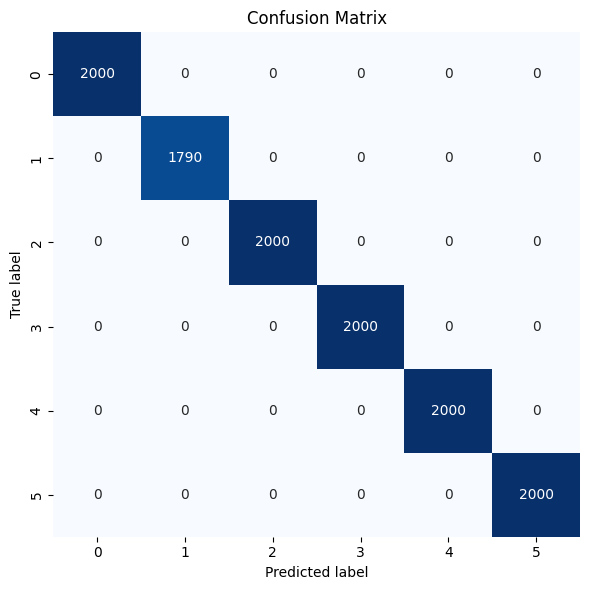

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      1790
           2       1.00      1.00      1.00      2000
           3       1.00      1.00      1.00      2000
           4       1.00      1.00      1.00      2000
           5       1.00      1.00      1.00      2000

    accuracy                           1.00     11790
   macro avg       1.00      1.00      1.00     11790
weighted avg       1.00      1.00      1.00     11790

Epoch 2/2
--------------------------------------------------


C:\Users\alira\AppData\Local\Temp\ipykernel_17312\2419795835.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.0013, Accuracy: 0.9995


C:\Users\alira\AppData\Local\Temp\ipykernel_17312\2419795835.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.0002, Accuracy: 0.9999
Loading best model weights...


C:\Users\alira\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\alira\AppData\Local\Temp\ipykernel_17312\2419795835.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a

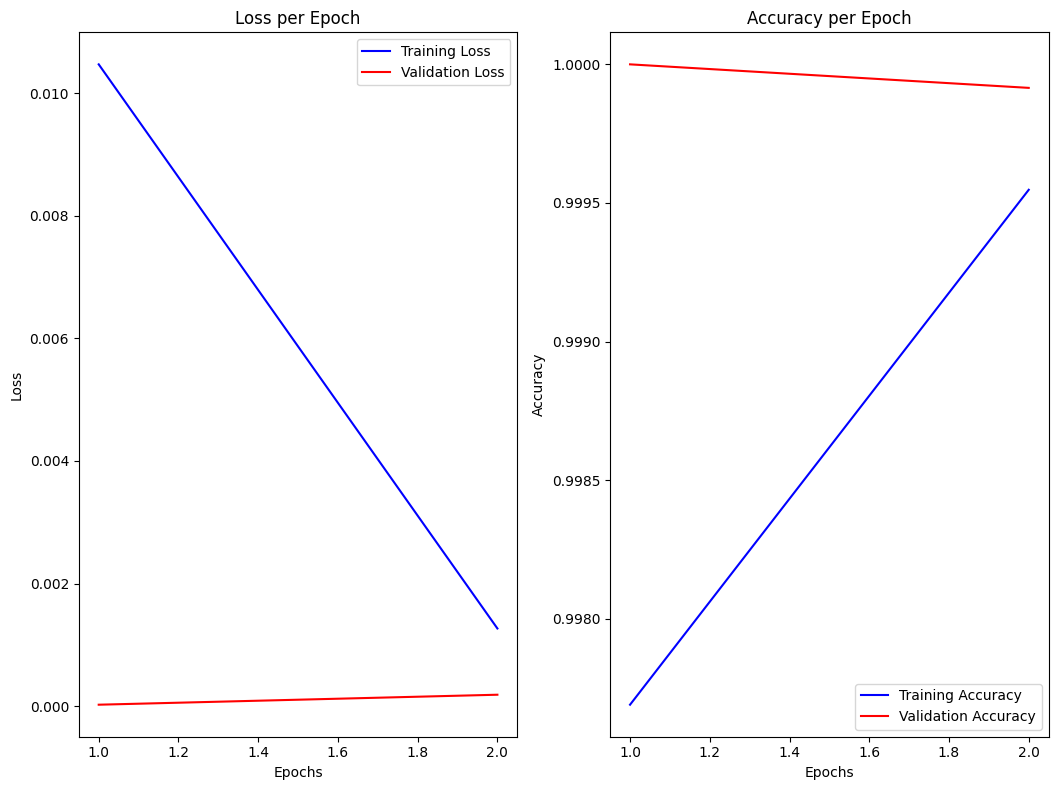

In [56]:
# Example:
early_stopping = EarlyStopping(patience=10, verbose=True, delta=0)
model_name_prefix = "model_resnext50_32_4d"  # Or dynamically change this per model
trained_model = train_and_validate(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    loss_fn,
    epochs=2,
    device=device,
    early_stopping=early_stopping,
    model_name_prefix=model_name_prefix)



C:\Users\alira\AppData\Local\Temp\ipykernel_17312\864929905.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test Loss: 0.0001, Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00       896
           2       1.00      1.00      1.00      1000
           3       1.00      1.00      1.00      1000
           4       1.00      1.00      1.00      1000
           5       1.00      1.00      1.00      1000

    accuracy                           1.00      5896
   macro avg       1.00      1.00      1.00      5896
weighted avg       1.00      1.00      1.00      5896



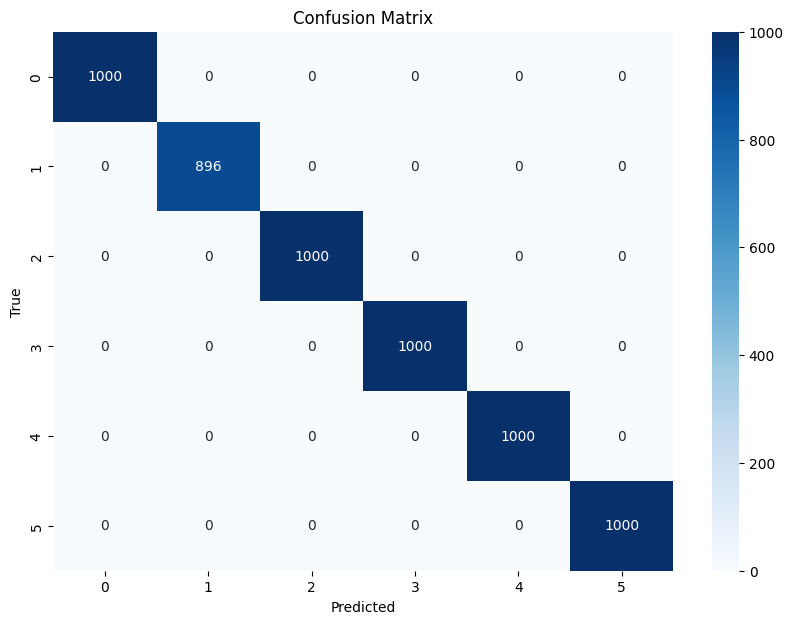

In [58]:
test_model(model, test_loader, loss_fn, device, num_classes=6)